![example](images/director_shot.jpeg)

# Movie Analysis: Movie Development/Rollout Strategy

**Authors:** Patrick Parkinson
***

## Overview

This project analyzes movie attribute and performance metric data found from IMBD and The Numbers to help Microsoft's new Movie Studio better determine what movie types and rollout strategies will be most effective. The data analysis shows that movie profitability and ratings vary by runtime, release date, and genre. Microsoft can use this information to rollout the most cost efficient and popular film offering.


ADD LINKS######################3

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

As a leading technology company, Microsoft is looking to expand their product offering to include original movie content. The Microsoft Movie Studio will compete directly with leading video content providers such as Netflix, HBO, and Hulu providing additional revenue streams while expanding their customer base for direct marketing of separate products and services. Microsoft is looking to complete an initial investigation into the performance of films in the movie industry to better understand the types of movies and launch strategies that are most effective. As a new film producer it will be critical for Microsoft to efficiently invest in their initial films while developing content that users enjoy. For this reason Return on investment (ROI) and viewer ratings have been analyzed against film attributes such as genre, runtime, and release date to guide Microsoft's initial film strategy.    

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding 



The data used for this analysis is from the following sources:

- IMBD: Leading online database for films including various movie attributes and viewer reviews. Data for this analysis is located within a SQLite database
- The Numbers (TN): Data website that tracks box office revenue by film. Data for this analysis is located in a .csv file

Target variables for analysis include the following:

- Performance metrics
 - Production budget and worldwide income (TN): Used the calculate a worldwide return on investment to understand the efficiency of the movie investment
 - Average rating (IMBD): Used to understand how well the movie was received by viewers
- Movie attributes (IMBD)
 - Runtime
 - Release date
 - Genre

***
Questions to consider:
* What do the data represent? Who is in the sample and what variables are included?
***ADD LINKS***############################################


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import sqlite3

%matplotlib inline

### Initial Data Review 


#### IMBD 

IMBD Initial Data Review: 
 - Data base queried for target variables and joins performed to generate `basic_rate_df` dataframe
 - Missing values in runtime and genres identified but will hold off on addressing knowing we are joining with a smaller TN data set
 - Genres will need to be exploded to isolate each genre tagged to each movie

In [2]:
#tried to format into separate lines for proper formating but couldn't maintain functionality
conn = sqlite3.Connection(r'C:\Users\Patrick Parkinson\Documents\Flatiron\Projects\Project 1\Working_Repository\Movie-Analysis\zippedData\SQL_data\im.db')

In [3]:
#Joing movie_basics and movie_ratings to access title, runtime, genres, rating, release date

q = """
SELECT *
FROM movie_basics
JOIN movie_ratings
  USING(movie_id)

"""
basic_rate_df = pd.read_sql(q, conn)
basic_rate_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [4]:
basic_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


#### The Numbers

TN Initial Data Review: 
 - Data read into `budget_gross_df` dataframe
 - No missing values. Plan to join on `primary_title` (`basic_rate_df`) to `movie` (`budget_gross_df`). Investigated  primary_title vs. original_title below to confirm selection in `basic_rate_df`
 - Poduction_budget, domestic_gross, and worldwide_gross all in string format with dollar sign, need to remove symbol and change to int to produce ROI

In [5]:
budget_gross_df = pd.read_csv(r'C:\Users\Patrick Parkinson\Documents\Flatiron\Projects\Project 1\Working_Repository\Movie-Analysis\zippedData\tn.movie_budgets.csv.gz')
budget_gross_df.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
budget_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
#highlighting where 'primary_title' differs from 'original_title'
basic_rate_df[basic_rate_df.primary_title != basic_rate_df.original_title]


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
8,tt0154039,So Much for Justice!,Oda az igazság,2010,100.0,History,4.6,64
10,tt0162942,Children of the Green Dragon,A zöld sárkány gyermekei,2010,89.0,Drama,6.9,120
12,tt0176694,The Tragedy of Man,Az ember tragédiája,2011,160.0,"Animation,Drama,History",7.8,584
...,...,...,...,...,...,...,...,...
73804,tt9875852,The House Elf,Domovoy,2019,90.0,"Comedy,Family,Fantasy",5.8,50
73824,tt9894394,Upin & Ipin: The Lone Gibbon Kris,Upin & Ipin: Keris Siamang Tunggal,2019,100.0,Animation,8.1,301
73829,tt9899840,Auntie Frog,Khaleh Ghurbagheh,2018,81.0,"Adventure,Comedy,Family",6.2,6
73830,tt9899850,The Agitation,Ashoftegi,2019,NaN,"Drama,Thriller",4.9,14


The `primary_title` and `original_title` only seem to differ when original title in different language so `primary_title` is the correct column to join with `movie`.

## Data Preparation

Key data preparation steps highlighted below:
- A 1 to 1 inner merge was completed between `basic_rate_df` (IMBD) and `budget_gross_df` (TN) into `br_inc_merged` dataframe to determine which movies overlapped between the dataframes
- Missing values were then addressed 
- Feature engineering and data formatting was then performed to produce worldwide ROI and release month
- Separate dataframe was generated to allow for genre analysis with single genre tag per movie
- Outliers are addressed in EDA section


### Data Merge


In [8]:
br_inc_merged = basic_rate_df.merge(budget_gross_df, how='inner', 
                                    left_on='primary_title', 
                                    right_on='movie')
print('br_inc_merged length:',len(br_inc_merged))
br_inc_merged.head()

br_inc_merged length: 2875


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,tt0326592,The Overnight,The Overnight,2010,88.0,None,7.5,24,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"
2,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"
3,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"
4,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"


In [9]:
br_inc_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2875 entries, 0 to 2874
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2875 non-null   object 
 1   primary_title      2875 non-null   object 
 2   original_title     2875 non-null   object 
 3   start_year         2875 non-null   int64  
 4   runtime_minutes    2757 non-null   float64
 5   genres             2867 non-null   object 
 6   averagerating      2875 non-null   float64
 7   numvotes           2875 non-null   int64  
 8   id                 2875 non-null   int64  
 9   release_date       2875 non-null   object 
 10  movie              2875 non-null   object 
 11  production_budget  2875 non-null   object 
 12  domestic_gross     2875 non-null   object 
 13  worldwide_gross    2875 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 336.9+ KB


In [10]:
#calcuting the percent of missing runtime data out of total dataset 
missing_runtime=(len(br_inc_merged[br_inc_merged['runtime_minutes'].isna()])
                 / len(br_inc_merged))*100
print('% missing runtime data:', missing_runtime)

% missing runtime data: 4.104347826086956


`br_inc_merged` Initial Review:
- Merge between `basic_rate_df` and `budget_gross_df` yielded 2875 overlapping movies. This is considerably less than 75k+ in SQL database but plan to use only overlapping values as ROI data is critical metric for planning
- `Runtime minutes` still has missing data points. Decision to remove these datapoints as they only represent 4% of total entries. Runtime is also a unique characteristics to each movie and therefore there isn't any great method to make accurate estimations for this value.
- It is possible that we aren't yielding all matches between the `basic_rate_df` and `budget_gross_df` if there are slight differents in the titles listed between datasets for the same movie. Exploring this below with a combined and sorted series of the titles between datasets. From review, there does not appear to be consistent formatting differences/typos that can be fixed to yield more data points. 

### Data Cleaning

In [11]:
#dropping missing values
br_inc_merged.dropna(inplace=True)

In [12]:
#confirmed droped
br_inc_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2752 entries, 0 to 2873
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2752 non-null   object 
 1   primary_title      2752 non-null   object 
 2   original_title     2752 non-null   object 
 3   start_year         2752 non-null   int64  
 4   runtime_minutes    2752 non-null   float64
 5   genres             2752 non-null   object 
 6   averagerating      2752 non-null   float64
 7   numvotes           2752 non-null   int64  
 8   id                 2752 non-null   int64  
 9   release_date       2752 non-null   object 
 10  movie              2752 non-null   object 
 11  production_budget  2752 non-null   object 
 12  domestic_gross     2752 non-null   object 
 13  worldwide_gross    2752 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 322.5+ KB


Additional analysis to below confirm there aren't any title formatting or typos we can correct to yield more matches. No recognizable patterns observed. Decision to move forward with 2752 data points

In [13]:
# combines titles in both datasets into single series to visualize whether there are repeated 
# typos/formatting differences that could be corrected

#allowing all rows to be displayed
pd.set_option('display.max_rows', 10000) 

#creating vars for each movie title series from two different dataframes
basic_rate_pt = basic_rate_df['primary_title'].copy()
budget_gross_pt = budget_gross_df['movie'].copy()

#concat two series together 
pt_concat = pd.concat([basic_rate_pt, budget_gross_pt])

#dropping duplicates so we're only seeing those that aren't included in merge
pt_concat.drop_duplicates(inplace=True)

#sorting alphabetically so potential typos/format differences can be seen
pt_concat.sort_values(ascending=True, inplace=True)

#adjust to view different portion of series
print(pt_concat.iloc[10000: 20000])

1594                                           Bodhisattva
43551                                               Bodhon
57376                                               Bodied
25915                                               Bodies
69044                                       Bodies at Rest
53953                                           Bodkin Ras
61911                                                 Bodo
38546                                                Bodom
7135                                                  Body
13907                                        Body Complete
3640                                           Body Double
61950                                        Body Electric
53643                                            Body Farm
21290                               Body Fat Index of Love
24422                                            Body High
39719                                         Body Keepers
13369                                        Body Langua

### Feature Engineering

Note on below  : 
- It is assumed that `production_budget` is the equivalent of the actual money used to produce to movie for the calculation of `worldwide_income` and `worldwide_ROI`
- `worldwide_ROI` was used in analysis instead of domestic ROI since Microsoft is a global corporation and will be launching their movies on an international scale
- A separate `release_month` was created from `release_date` to create managable bins for data aggregation and analysis

In [14]:
#run once to remove $ signs and change dollar amounts from string to int
br_inc_merged['production_budget'] = br_inc_merged['production_budget'].str.replace(
                                     r'[^\w\s]+', '').astype('int64')

br_inc_merged['worldwide_gross'] = br_inc_merged['worldwide_gross'].str.replace(
                                   r'[^\w\s]+', '').astype('int64')


In [15]:
#calculating worldwide ROI
br_inc_merged['worldwide_income'] = br_inc_merged['worldwide_gross']
- br_inc_merged['production_budget'] #tried formating like below but getting 'unexpected indent error'

br_inc_merged['worldwide_ROI'] = (br_inc_merged['worldwide_income']
                                  / br_inc_merged['production_budget'])*100

In [16]:
#changing format of release date to datetime
br_inc_merged['release_date'] = pd.to_datetime(br_inc_merged['release_date'])

In [17]:
#creating column with release month
br_inc_merged['release_month'] = br_inc_merged['release_date'].dt.month_name()
#creating column with release month as number (future sorting ops)
br_inc_merged['release_month_num'] = br_inc_merged['release_date'].dt.month

In [18]:
br_inc_merged.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_income,worldwide_ROI,release_month,release_month_num
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,2012-12-31,Foodfight!,45000000,$0,73706,73706,0.163791,December,12
2,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,21,2015-06-19,The Overnight,200000,"$1,109,808",1165996,1165996,582.998000,June,6
3,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,17,2013-03-22,On the Road,25000000,"$720,828",9313302,9313302,37.253208,March,3
4,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,17,2013-03-22,On the Road,25000000,"$720,828",9313302,9313302,37.253208,March,3
5,tt5647250,On the Road,On the Road,2016,121.0,Drama,5.7,127,17,2013-03-22,On the Road,25000000,"$720,828",9313302,9313302,37.253208,March,3


In [19]:
br_inc_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2752 entries, 0 to 2873
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2752 non-null   object        
 1   primary_title      2752 non-null   object        
 2   original_title     2752 non-null   object        
 3   start_year         2752 non-null   int64         
 4   runtime_minutes    2752 non-null   float64       
 5   genres             2752 non-null   object        
 6   averagerating      2752 non-null   float64       
 7   numvotes           2752 non-null   int64         
 8   id                 2752 non-null   int64         
 9   release_date       2752 non-null   datetime64[ns]
 10  movie              2752 non-null   object        
 11  production_budget  2752 non-null   int64         
 12  domestic_gross     2752 non-null   object        
 13  worldwide_gross    2752 non-null   int64         
 14  worldwid

In [20]:
#UPDATE THIS BASED ON WHAT YOU ACTUALLY USE
br_inc_merged.drop(['original_title','start_year', 
                    'numvotes', 'id', 'movie',
                    'domestic_gross'], axis=1, inplace=True)

A separate dataframe (`genre_df`) was created for genres with individual genre tags per movie. This allows the bulk of the analysis to be performed on `br_inc_merged` which with 1 to 1 relationship (no repeat movies)

In [21]:
genre_df = br_inc_merged.copy()

In [22]:
genre_df['genres'] = genre_df['genres'].str.split(',')

In [23]:
genre_df = genre_df.explode('genres')
genre_df.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,worldwide_gross,worldwide_income,worldwide_ROI,release_month,release_month_num
0,tt0249516,Foodfight!,91.0,Action,1.9,2012-12-31,45000000,73706,73706,0.163791,December,12
0,tt0249516,Foodfight!,91.0,Animation,1.9,2012-12-31,45000000,73706,73706,0.163791,December,12
0,tt0249516,Foodfight!,91.0,Comedy,1.9,2012-12-31,45000000,73706,73706,0.163791,December,12
2,tt3844362,The Overnight,79.0,Comedy,6.1,2015-06-19,200000,1165996,1165996,582.998000,June,6
2,tt3844362,The Overnight,79.0,Mystery,6.1,2015-06-19,200000,1165996,1165996,582.998000,June,6


## Analysis

Key analysis steps
- EDA was performed to produce descriptive statistics on target variables
- `worldwide_ROI` has a large range of values. Extreme outliers were analyzed and dropped to ensure data was not skewed
- Correlation analysis performed to determine any strong variable relationships between movie attributes and performance metrics
- Aggregate buckets created for runtime and rating analyses

### Exploratory Data Analysis and Outlier Cleanup 

In [24]:
br_inc_merged.describe()

,runtime_minutes,averagerating,production_budget,worldwide_gross,worldwide_income,worldwide_ROI,release_month_num
count,2752.000000,2752.000000,2.752000e+03,2.752000e+03,2.752000e+03,2752.000000,2752.000000
mean,102.972020,6.243132,3.473329e+07,1.043842e+08,1.043842e+08,405.019968,6.965843
std,20.786121,1.168073,4.822579e+07,2.034297e+08,2.034297e+08,1493.227031,3.506384
min,3.000000,1.600000,1.400000e+03,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,90.000000,5.600000,5.000000e+06,2.229406e+06,2.229406e+06,30.936624,4.000000
50%,101.000000,6.400000,1.785000e+07,3.007543e+07,3.007543e+07,158.644429,7.000000
75%,113.250000,7.100000,4.000000e+07,1.030832e+08,1.030832e+08,358.142857,10.000000
max,280.000000,9.200000,4.250000e+08,2.776345e+09,2.776345e+09,41656.474000,12.000000


In [25]:
print('Medians:')
print(br_inc_merged.median())

Medians:
runtime_minutes      1.010000e+02
averagerating        6.400000e+00
production_budget    1.785000e+07
worldwide_gross      3.007543e+07
worldwide_income     3.007543e+07
worldwide_ROI        1.586444e+02
release_month_num    7.000000e+00
dtype: float64


<ipython-input-25-4b665f30bc90>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(br_inc_merged.median())


#### Average Rating

EDA Review:
- Average rating has fairly even distribution with mean and median in close alignment although most common rating is skewed to the right.

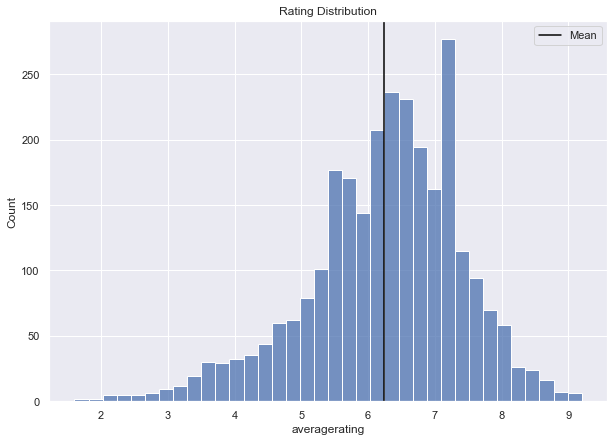

In [26]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(10,7))
g = sns.histplot(data=br_inc_merged['averagerating'], ax=ax)
g.set(title='Rating Distribution')
g.axvline(x=br_inc_merged['averagerating'].mean(), color='black', label='Mean')
g.legend(loc='upper right')

#### Runtime

EDA Review:
- Runtime has fairly even distribution with mean and median in close alignment although most common rating is skewed to the left.
- There are a few datapoints at the far end of the distribution that could be outliers. Decision to include in dataset to investigate impact on performance metrics  knowing it can be filtered during analysis.

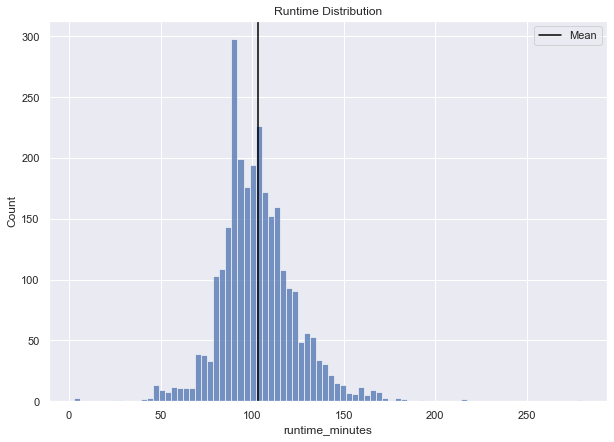

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
g=sns.histplot(data=br_inc_merged['runtime_minutes'], ax=ax)
g.set(title='Runtime Distribution')
g.axvline(x=br_inc_merged['runtime_minutes'].mean(), color='black', label='Mean')
g.legend(loc='upper right')

plt.savefig('runtime_distribution.png')

#### Worldwide Return on Investment (ROI)

EDA Review:
- `worldwide_ROI` is skewed heavily to the right with the bulk of the distribution in the -75% - 750% with the IQR from -70% to 260% (see boxplot)
- As one of the primary goals of Microsoft's Movie Studio is to maximize ROI I did not want to remove a large amount of outliers; however, if kept these outliers could skew the bulk of the data during analysis. The following approach was taken to address this:
 - There are 5 data points with ROI greater than 20,000%. These were considered extreme outliers and were removed from the dataset
 - A mask was created to allow filtering out of the top 5% performers during data analysis

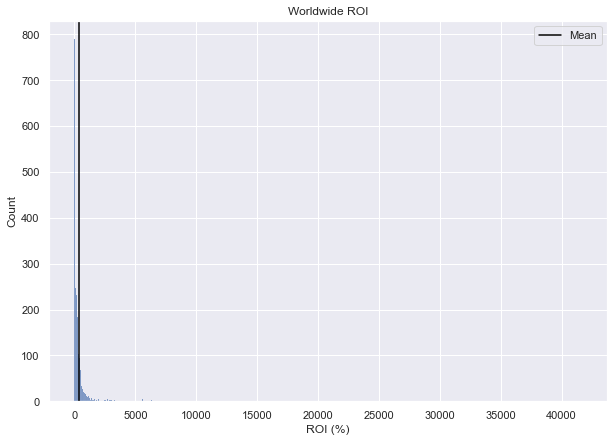

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
g = sns.histplot(data=br_inc_merged['worldwide_ROI'], ax=ax)
g.set(title='Worldwide ROI', xlabel='ROI (%)');
g.axvline(x=br_inc_merged['worldwide_ROI'].mean(), color='black', label='Mean')
g.legend(loc='upper right')
g.set_xticks(range(0, 45000, 5000));



(-1000.0, 5000.0)

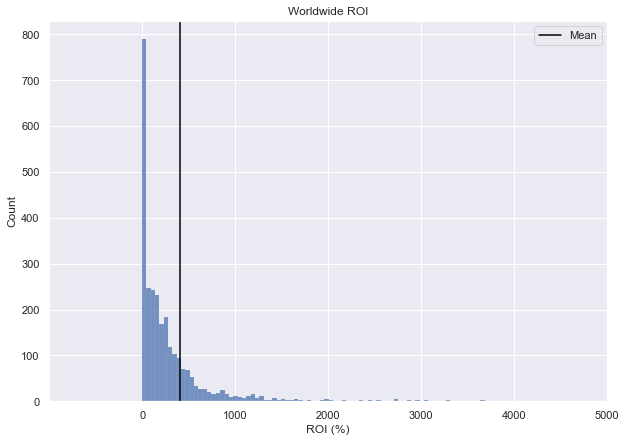

In [29]:
#same distribution as above but zoomed in

fig, ax = plt.subplots(figsize=(10,7))
g = sns.histplot(data=br_inc_merged['worldwide_ROI'], ax=ax)
g.set(title='Worldwide ROI', xlabel='ROI (%)');
g.axvline(x=br_inc_merged['worldwide_ROI'].mean(), color='black', label='Mean')
g.set_xticks(range(0, 45000, 1000));
g.legend(loc='upper right')

plt.xlim([-1000, 5000])

C:\Users\Patrick Parkinson\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


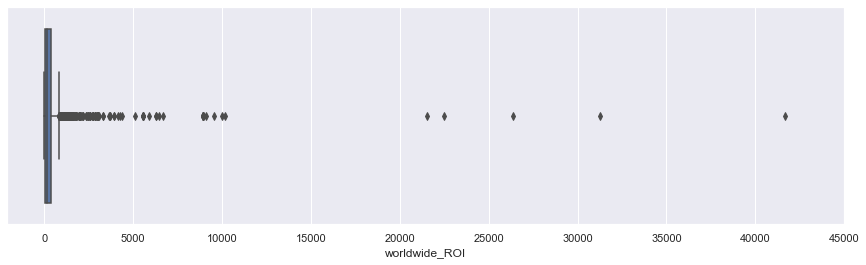

In [30]:
ax, fig = plt.subplots(figsize=(15,4))
g = sns.boxplot(br_inc_merged['worldwide_ROI']);
g.set_xticks(range(0, 50000, 5000));


C:\Users\Patrick Parkinson\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-500.0, 900.0)

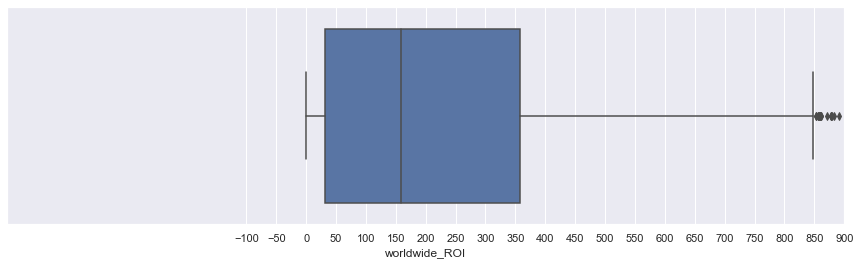

In [31]:
#same boxplot as above but zoomed in

ax, fig = plt.subplots(figsize=(15,4))
g = sns.boxplot(br_inc_merged['worldwide_ROI']);
g.set_xticks(range(-100, 50000, 50));
# xlabels = ['{:,.0f}'.format(x) + 'M' for x in g.get_xticks()/1000000];
# g.set_xticklabels(rotation=45);

plt.xlim([-500, 900])

Even with outliers above 20,000% removed, this still leaves considerable amount of high ROIs that could throw off results. Create mask to filter out top 5% of ROIs for use during analysis

In [32]:
#finding value at 95th quantile
ROI_quant_95 = br_inc_merged['worldwide_ROI'].quantile(0.95)
print('ROI 95th Quantile:', ROI_quant_95)

ROI 95th Quantile: 1186.6198484999993


In [33]:
ROI_max = br_inc_merged['worldwide_ROI'].max()

#calculating average ROI of top 5% 
ROI_top5_ave = br_inc_merged[(br_inc_merged['worldwide_ROI'] > ROI_quant_95) & 
             (br_inc_merged['worldwide_ROI'] < ROI_max)]['worldwide_ROI'].mean()

print('Top 5% ROI, Average:', ROI_top5_ave)

Top 5% ROI, Average: 3650.439414425255


In [34]:
#mask filters out top 5% of ROI performers for use in analysis
ROI_95th_mask = br_inc_merged['worldwide_ROI'] < ROI_quant_95

#### Genre

EDA Review:
- The number of movies by genre is graphed below
- There is a vast different in the number of numbers for each genre. This is important to consider when investigating the top performing genres as we may not be comparing similar sample size. Genres with counts less than 50 movies were removed to ensure data is coming from a reasonably sized sample size

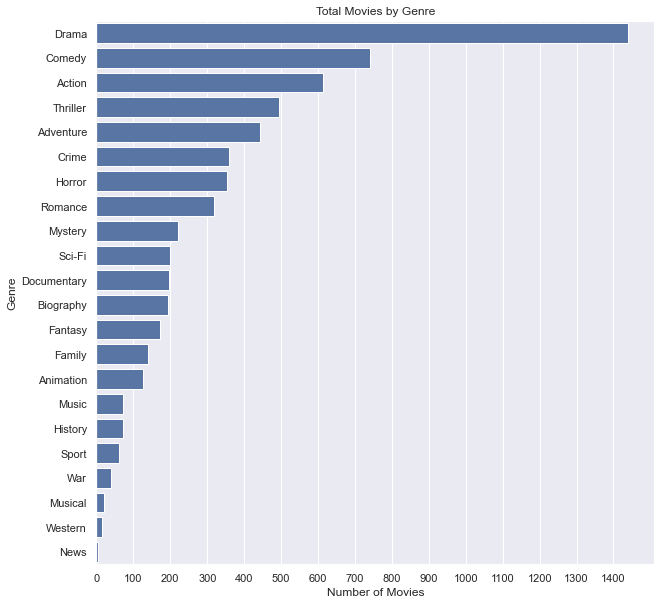

In [35]:
#produce df of genre counts
genre_df_counts = genre_df.groupby('genres', as_index=False).count()

fig, ax = plt.subplots(figsize=(10,10))
data_genre_counts = genre_df_counts.sort_values(by='movie_id', ascending=False);
g = sns.barplot(data=data_genre_counts, x='movie_id', y='genres', ax=ax, color='b')
g.set(title='Total Movies by Genre', xlabel='Number of Movies', ylabel='Genre');
g.set_xticks(range(0, 1500, 100));

#### Release Date 

EDA Review:
- The number of movie released per calendar month is shown below
- Hard to fully discern from this graph but there appears to be some seasonality in the number of movies released with 4 waves peaking in March/April (potentially targeting spring break vacations), June (potentially targeting start of summer), Sept/Oct/Nov (potentially targeting beginning of holiday season), December (likely largest peak due to holiday season). Movies released around holidays could mean more theatre viewings but could also mean more competition as several movies are being released. 

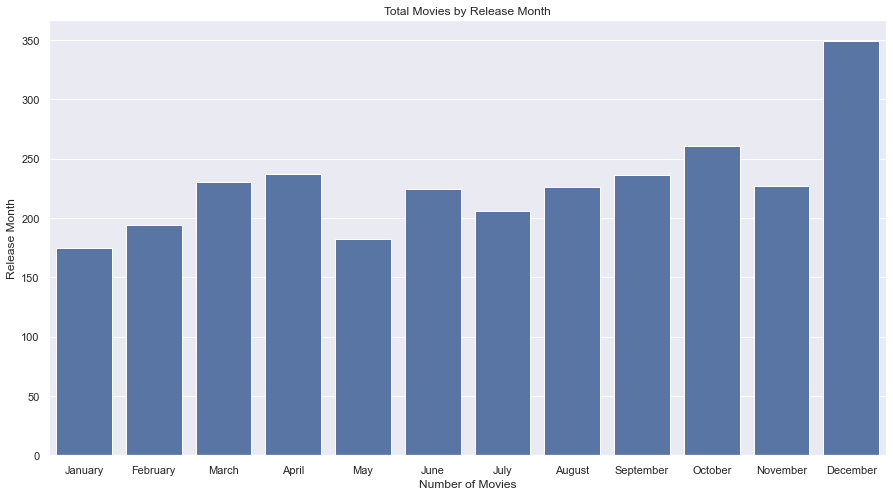

In [99]:

#month dict for sorting 
month_dict = {'January':1,'February':2,'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
#counting by release_month
date_count_df = br_inc_merged.groupby('release_month', as_index=False).count()
#sorting by date number in month dict
date_count_df_sorted = date_count_df.sort_values(by='release_month', key=lambda x: x.apply (lambda x: month_dict[x]))

fig, ax = plt.subplots(figsize=(15,8))
g = sns.barplot(data=date_count_df_sorted, y='movie_id', x='release_month', ax=ax, color='b')
g.set(title='Total Movies by Release Month', xlabel='Number of Movies', ylabel='Release Month');


#### Outlier Cleanup

Per above, the following data are considered outliers and was dropped:
- `worldwide_ROI` > 20,000%
- `genres` with counts < 50

In [37]:
#finding index to drop in br_inc_merged df
index_drop = br_inc_merged[br_inc_merged['worldwide_ROI'] > 20000].index
#finding index to drop in br_inc_merged df
index_drop_genre = genre_df[(genre_df['worldwide_ROI'] > 20000)].index

#dropping data at index_drop
br_inc_merged.drop(index_drop, inplace=True)
genre_df.drop(index_drop_genre, inplace=True)




In [38]:
#dropping genres with less than 50 movies

#producing genre_counts series
genre_counts = genre_df['genres'].value_counts()
#finding index of genre's to remove in genre_counts series
genre_to_remove = genre_counts[genre_counts <= 50].index
#dropping values in genre_df based on genre_to_remove
genre_df = genre_df[~genre_df['genres'].isin(genre_to_remove)]

### Target Variable Analysis and Bucketing

First a quick correlation analysis was conducted on numerical variables of iterest see if there were any immediate relationships to explore. As shown below there is no strong correlation between any of the variables, therefore, data in `averagerating` and `runtime_minutes` were grouped into bins for further analysis via bar graph. 

In [39]:
corr_rating_ROI = br_inc_merged['averagerating'].corr(br_inc_merged['worldwide_ROI'])
corr_runtime_ROI = br_inc_merged['runtime_minutes'].corr(br_inc_merged['worldwide_ROI'])
corr_runtime_rating = br_inc_merged['runtime_minutes'].corr(br_inc_merged['averagerating'])

print('Correlation b/w rating and worldwide ROI:', corr_rating_ROI)
print('Correlation b/w runtime and worldwide ROI:', corr_runtime_ROI)
print('Correlation b/w runtime and rating:', corr_runtime_rating)

Correlation b/w rating and worldwide ROI: 0.05359983771306231
Correlation b/w runtime and worldwide ROI: -0.003223297938587429
Correlation b/w runtime and rating: 0.2125564489954962


Bucketing:
- `averagerating` was bucketed into groups of two rating levels
- `runtime_minutes` was grouped into 20 min intervals and datapoints at the far ends of the distribution were grouped together based on the EDA

In [40]:
#establishing bins of data -> values to cut by
bins_rating = [0, 2, 4, 6, 8, 10]
#establishing labels for bins
labels_rating = ['0-2','2-4','4-6','6-8','8-10']
#creating rating_bins column by cutting data per bins_rating and assigning labels_rating
br_inc_merged['rating_bins'] = pd.cut(br_inc_merged['averagerating'], 
                                      bins_rating, labels=labels_rating)

#repeat above proces for runtime
bins_runtime = [0, 50, 70, 90, 110, 130, 150, 170, 290]
labels_runtime = ['0-50','50-70','70-90','90-110',
                  '110-130','130-150','150-170','170-290']
br_inc_merged['runtime_bins'] = pd.cut(br_inc_merged['runtime_minutes'],
                                       bins_runtime, labels=labels_runtime)

#### Rating Investigation

Results:
- Top 5% of performers by ROI had a variety of ratings (from 2-4 group to 8-10 group)
- Per the `averagerating` distribution, there are very few movies in the 0-2 range so the relatively high ROI for these movies may be considered an anomaly 
- Without the top 5 performers there is a steady increase in ROI from ratings of 2 - 8, stabalizing in the 6-10 range
- Full dataset with top 5 performers follow a similar trend with the highest ROIs occuring with ratings in the 8-10 category

In [41]:
#aggregating by rating_bins and calculating mean
rating_means_df = br_inc_merged.groupby('rating_bins', as_index=False).mean()
#aggregating by rating_bins and calculating mean up to 95th percentile 
rating_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('rating_bins', 
                                                            as_index=False).mean()

<ipython-input-41-7f761851a015>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rating_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('rating_bins', as_index=False).mean()


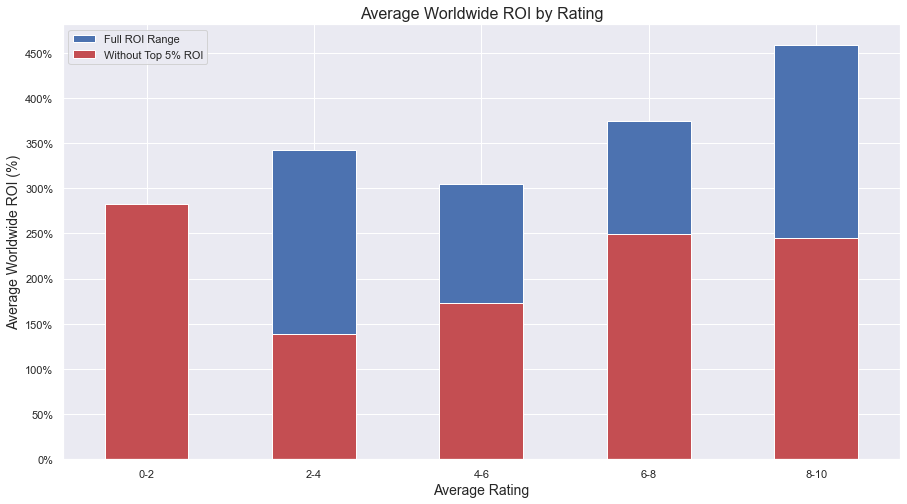

In [92]:
fig, ax = plt.subplots(figsize=(15,8))
g=rating_means_df.plot.bar(ax=ax, rot=0, x='rating_bins', y='worldwide_ROI', color='b')
g=rating_means_95th_df.plot.bar(ax=ax, rot=0, x='rating_bins', y='worldwide_ROI', color='r')
plt.legend(labels=['Includes Top 5% ROI', 'Excludes Top 5% ROI'])

g.set_yticks(range(0, 500, 50));
#adding % to y-axis labels
ylabels = ['{:,.0f}'.format(y) + '%' for y in g.get_yticks()];
g.set_yticklabels(ylabels);

ax.set_title('Average Worldwide ROI by Rating', fontsize=16)
ax.set_xlabel('Average Rating', fontsize=14)
ax.set_ylabel('Average Worldwide ROI (%)', fontsize=14);

In [43]:
#CREATE SECOND IMAGE FOR REPORT WITHOUT 0-2

#### Release Date Analysis

Results: -> REVISIT
- There is no clear pattern in ROI by release date when looking at the full dataset although the range in ROIs for the full data set is much higher than that of movies in the 95% percentile 
 - Full ROI Data Set: Average ROIs range from around 225% to 625%
 - Without top 5%: Average ROIs range from around 175% to 260%
- When the top 5% ROI movies are removed, movies released in January, June, and  November produce the highest ROI

In [52]:
#aggregating by release_month, calculating mean, and sorting by month number
date_means_df = br_inc_merged.groupby('release_month', 
                                      as_index=False).mean().sort_values(by='release_month_num')
#same as above with 95 percentile mask
date_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('release_month', 
                                                          as_index=False).mean().sort_values(by='release_month_num')

<ipython-input-52-27d00ea5afe3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  date_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('release_month', as_index=False).mean().sort_values(by='release_month_num')


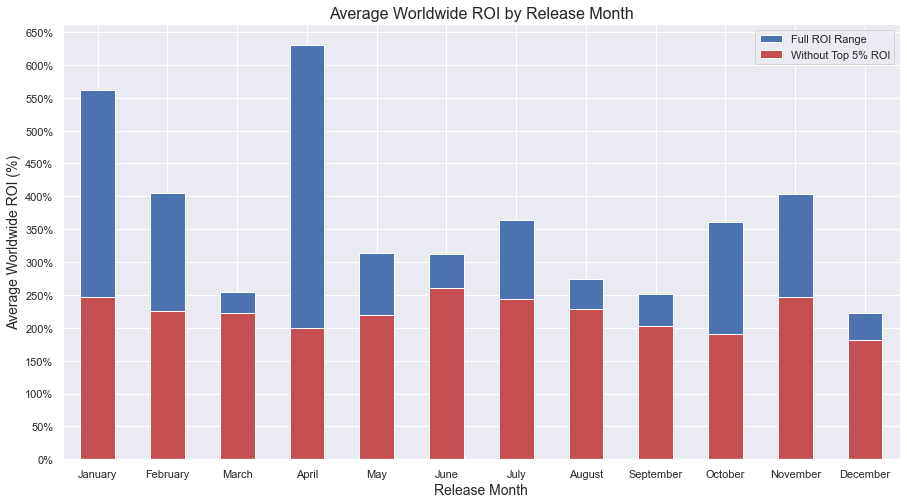

In [91]:
fig, ax = plt.subplots(figsize=(15,8))
g=date_means_df.plot.bar(ax=ax, rot=0, x='release_month', y='worldwide_ROI', color='b')
g=date_means_95th_df.plot.bar(ax=ax, rot=0, x='release_month', y='worldwide_ROI', color='r')
plt.legend(labels=['Includes Top 5% ROI', 'Excludes Top 5% ROI'])

g.set_yticks(range(0, 700, 50));
ylabels = ['{:,.0f}'.format(y) + '%' for y in g.get_yticks()];
g.set_yticklabels(ylabels);

ax.set_title('Average Worldwide ROI by Release Month', fontsize=16)
ax.set_xlabel('Release Month', fontsize=14)
ax.set_ylabel('Average Worldwide ROI (%)', fontsize=14);

#### Runtime Analysis

Results:
- Top 5% ROI performers were observed from 70 - 170min total runtime.
- There is a steady increase in ROI for movies excluding the top 5% from 70min to 130-150min which starts to level off and decrease at 150-170min
- There is a steady increase in average rating in runtimes from 70 to 290min
- According to the `runtime_minutes` EDA, there are few movies with runtimes less than 70min although their ROI and average rating are in the middle of the field. Possible that the higher ROI is due to lower required investment but this short of runtime is very uncommon in today's movie industry and therefore likely wouldn't be recommended 

In [56]:
#aggregating by runtime_bins and calculating mean
runtime_means_df = br_inc_merged.groupby('runtime_bins', as_index=False).mean()
runtime_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('runtime_bins', as_index=False).mean()

<ipython-input-56-8f5fc8f64ad3>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  runtime_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('runtime_bins', as_index=False).mean()


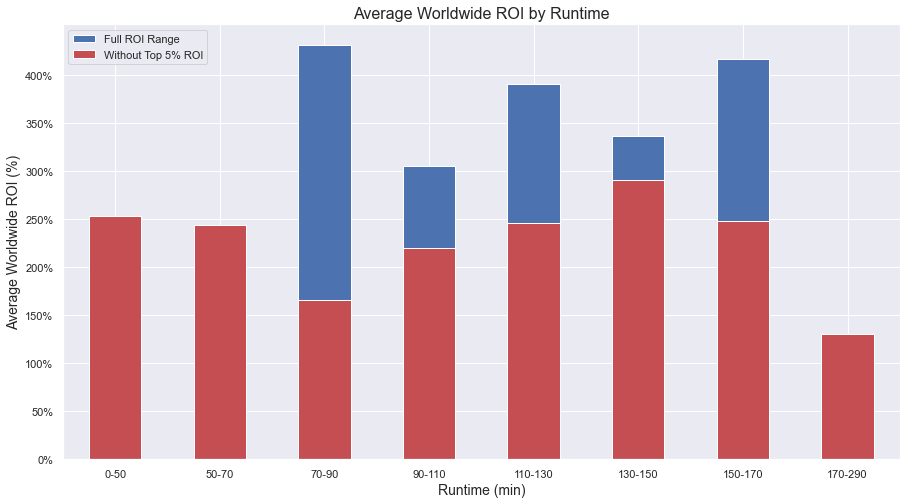

In [88]:
fig, ax = plt.subplots(figsize=(15,8))
g=runtime_means_df.plot.bar(ax=ax, rot=0, x='runtime_bins', y='worldwide_ROI', color='b')
g=runtime_means_95th_df.plot.bar(ax=ax, rot=0, x='runtime_bins', y='worldwide_ROI', color='r')
plt.legend(labels=['Includes Top 5% ROI', 'Excludes Top 5% ROI'])

g.set_yticks(range(0, 450, 50));
ylabels = ['{:,.0f}'.format(y) + '%' for y in g.get_yticks()];
g.set_yticklabels(ylabels);

ax.set_title('Average Worldwide ROI by Runtime', fontsize=16)
ax.set_xlabel('Runtime (min)', fontsize=14)
ax.set_ylabel('Average Worldwide ROI (%)', fontsize=14);

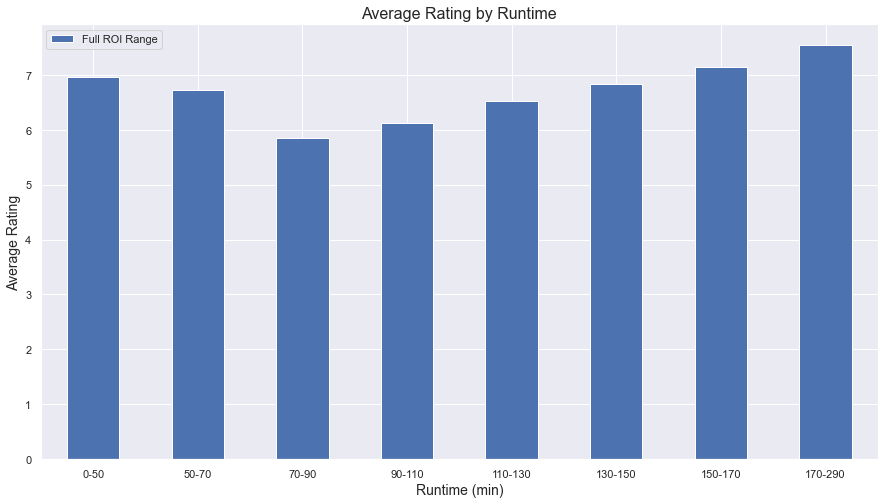

In [90]:
fig, ax = plt.subplots(figsize=(15,8))
g=runtime_means_df.plot.bar(ax=ax, rot=0, x='runtime_bins', y='averagerating', color='b')
plt.legend(labels=['Full ROI Range'])

ax.set_title('Average Rating by Runtime', fontsize=16)
ax.set_xlabel('Runtime (min)', fontsize=14)
ax.set_ylabel('Average Rating', fontsize=14);


#### Genre Analysis

Results:
- There is a vast difference in ROIs for different movie genres 
 - Appears to be 3 groupings of average ROIs (those above 350%, those above 250%)
- Average rating varies from around 5 - 7 across different genres


In [95]:
#aggregating by genres and calculating means by worldwide ROI
genre_df_means = genre_df.groupby('genres', as_index=False).mean()

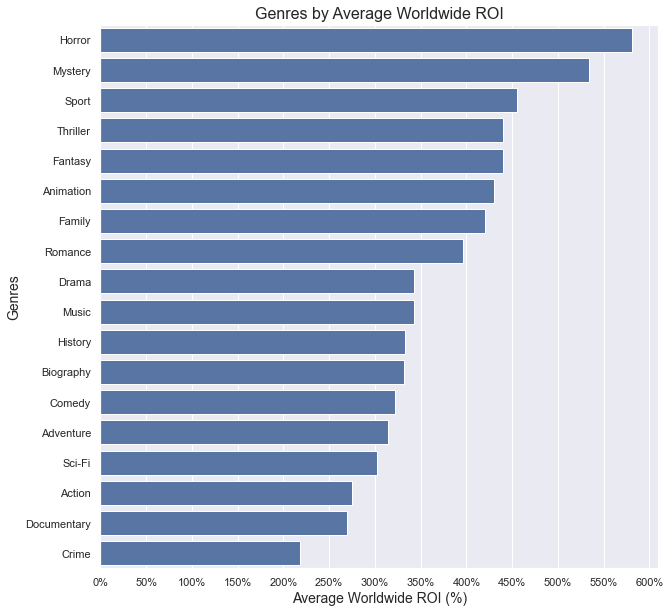

In [96]:
fig, ax = plt.subplots(figsize=(10,10))

data_mean_ROI = genre_df_means.sort_values(by='worldwide_ROI', ascending=False)
g = sns.barplot(data=data_mean_ROI, x='worldwide_ROI', y='genres', ax=ax, color='b')

g.set_xticks(range(0, 650, 50));
xlabels = ['{:,.0f}'.format(x) + '%' for x in g.get_xticks()];
g.set_xticklabels(xlabels);

ax.set_title('Genres by Average Worldwide ROI', fontsize=16)
ax.set_xlabel('Average Worldwide ROI (%)', fontsize=14)
ax.set_ylabel('Genres', fontsize=14);


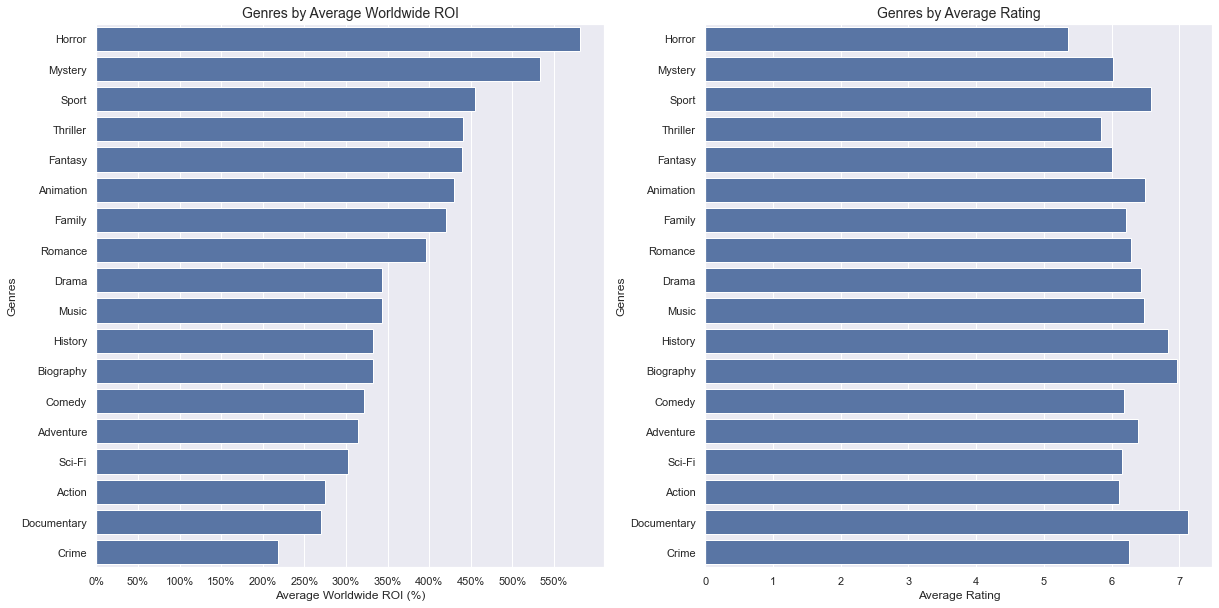

In [100]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

data_mean_ROI = genre_df_means.sort_values(by='worldwide_ROI', ascending=False)

g1 = sns.barplot(data=data_mean_ROI, x='worldwide_ROI', y='genres', ax=ax1, color='b')

g1.set_xticks(range(0, 600, 50));
xlabels = ['{:,.0f}'.format(x) + '%' for x in g1.get_xticks()];
g1.set_xticklabels(xlabels);

ax1.set_title('Genres by Average Worldwide ROI', fontsize=14)
ax1.set_xlabel('Average Worldwide ROI (%)', fontsize=12)
ax1.set_ylabel('Genres', fontsize=12)

g2 = sns.barplot(data=data_mean_ROI, x='averagerating', y='genres', ax=ax2, color='b')

ax2.set_title('Genres by Average Rating', fontsize=14)
ax2.set_xlabel('Average Rating', fontsize=12)
ax2.set_ylabel('Genres', fontsize=12);


Text(0, 0.5, 'Genres')

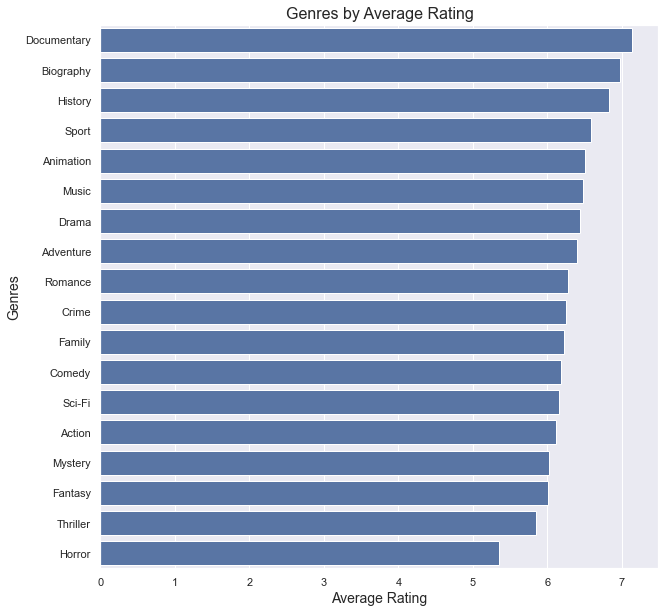

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
data_mean_reviews = genre_df_means.sort_values(by='averagerating', ascending=False);
g = sns.barplot(data=data_mean_reviews, x='averagerating', y='genres', ax=ax, color='b')

ax.set_title('Genres by Average Rating', fontsize=16)
ax.set_xlabel('Average Rating', fontsize=14)
ax.set_ylabel('Genres', fontsize=14)

## Conclusions




Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

### Recommendations

This analysis leads to three recommendations for movie development under the new Microsoft Movie Studio:
- **Release movies throughout the year to remain competitive but favor release dates around January, June, and November**. While hits can occur any time throughout the year, these months yielded the highest average ROI for the bulk of the movies reviewed. These months also correlate to times where the total number of movies released are lower (see release date EDA) which will allow for lower competition at the box office. 
- **Focus on movies with runtimes from 110 - 170min**. Movies with these runtimes have the highest ROI on average for the bulk of the movies analyzed. These runtimes also have the high ratings. While movies with higher runtimes had an even higher ratings there is not enough data available to make the determinations for movies in the highest runtime range. 
- **While a wide variety of genre's are recommended to compete with other movie content producers focus initial efforts on the following genres: sports, animation, family, romance**. These movies yielded both the highest ROI (greater than 375%) and the highest user ratings (greater than 6). 
- **User rating may be used as a metric to help track relative ROI performance for newly released movies**. On average ROI tended to increase for bulk of movies from 2 - 8 (leveling to 10) for the bulk of movies although there was no strong statistical correlation noted between these variables. 

### Next Steps / Considerations

The below notes have been included for consideration:
- Note that while that averages analyzed in this activity do show differences in ratings and ROI by movie attributes, there is no statistical correlation between these variables and movies produced according to these recommendations are not intended to predict results. There are several other variables that influence movie success but the relative differences in historical averages in this report are helpful in guiding movie selections. 
- In future it would be helpful to have a better understanding of the source of the raw data sets provided. It was not clear whether the IMBD or TN datasets only represented a certain population of movies which may skew the results and recommendations.
- The genre analysis compares genres against vastly different data sizes. In the future it would be helpful to have larger and more consistent sample sizes for each genre.
- In future, additional movie parameters should be examined to help guide development strategy such as producers, writers, and actors.
- In future, it would also be helpful to further define performance metrics to better understand where movie revenue is coming from (box office, merchandise, online streaming, etc.) so Microsoft can better plan it's commercialization strategy.